In [1]:
using PyPlot
using PyCall
using Printf
@pyimport matplotlib.animation as anim
@pyimport matplotlib.patches as patches

In [2]:
using Base64
function showanim(filename)
    base64_video = base64encode(open(filename))
    display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
end

showanim (generic function with 1 method)

In [3]:
mutable struct World
    objects
    debug
    time_span
    time_interval
    ani
end

World() = World([], false, 10, 1, nothing)
World(debug) = World([], debug, 10, 1, nothing)
World(time_span, time_interval) = World([], false, time_span, time_interval, nothing)

function append(self::World, obj)
    push!(self.objects, obj)
end

function init_draw(self::World, ax)
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
end

function draw(self::World)
    fig, ax = subplots()
    init_draw(self, ax)    
    elems = []

    if self.debug
        for i = 1:1000
            one_step(self, i, elems, ax)
        end
    else
        self.ani = anim.FuncAnimation(fig, one_step, fargs=(self, elems, ax), 
            frames = Int(self.time_span/self.time_interval)+1, interval = Int(self.time_interval*1000))
        self.ani[:save]("test.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    end 
    
end

function one_step(i,self::World, elems, ax)
    plt.cla()
    init_draw(self, ax)
    while length(elems) > 0
        pop!(elems)
    end
    vcat(elems, ax.text(-4.4, 4.5, string("t = ", @sprintf("%.2f[s]", self.time_interval * i) ), fontsize=10))
    for obj in self.objects
        draw(obj, ax, elems)
        if applicable(one_step, obj, 1.0)
            one_step(obj, 1.0)
        end
    end
end

one_step (generic function with 1 method)

In [4]:
mutable struct Agent
    nu
    omega
end
function decision(self::Agent, observation=nothing)
    return self.nu, self.omega
end

decision (generic function with 2 methods)

In [5]:
mutable struct IdealRobot
    pose
    r
    color
    agent
    poses
    sensor
end

IdealRobot(pose) = IdealRobot(pose, 0.2, "black", nothing, [pose], nothing)
IdealRobot(pose, color) = IdealRobot(pose, 0.2, color, nothing, [], nothing)
IdealRobot(pose, agent) = IdealRobot(pose, 0.2, "black", agent, [pose], nothing)
IdealRobot(pose, agent, color) = IdealRobot(pose, 0.2, color, agent, [pose], nothing)
IdealRobot(pose, agent, sensor, color) = IdealRobot(pose, 0.2, color, agent, [pose], sensor)

function draw(self::IdealRobot, ax, elems)
    x,y,theta = self.pose
    xn = x + self.r * cos(theta)
    yn = y + self.r * sin(theta)
    elems = vcat(elems, ax.plot([x, xn], [y,yn], color = self.color))
    c = patches.Circle(xy=(x,y), radius = self.r, fill = false, color = self.color)
    elems = vcat(elems, [ax.add_patch(c)])
    
    push!(self.poses, self.pose)
    elems = vcat(elems, ax.plot([e[1] for e in self.poses], [e[2] for e in self.poses], linewidth=0.5, color="black"))
    
    if !isnothing(self.sensor) && length(self.poses) > 1
        draw(self.sensor, ax, elems, self.poses[length(self.poses)-1])
    end
end

function state_transition(self::IdealRobot, nu, omega, time)
    t0 = self.pose[3]
    if abs(omega) < 1e-10
        return self.pose + [nu*cos(t0), nu*sin(t0), omega].*time
    else
        return self.pose + [nu/omega*(sin(t0+omega*time)-sin(t0)),
                                  nu/omega*(-cos(t0+omega*time)+cos(t0)),
                                 omega*time]
    end
end

function one_step(self::IdealRobot, time_interval)
    if isnothing(self.agent)
        return
    end
    obs = nothing
    if !isnothing(self.sensor)
        obs = data(self.sensor, self.pose)
    end
    nu, omega = decision(self.agent, obs)
    self.pose = state_transition(self, nu, omega, time_interval)
end

one_step (generic function with 2 methods)

In [6]:
mutable struct Landmark
    pos
    id
end

Landmark(pos) = Landmark(pos, nothing)

function draw(self::Landmark, ax, elems)
    c = ax.scatter(self.pos[1], self.pos[2], s=100, marker="*", label="landmarks", color="orange")
    elems = vcat(elems, c)
    elems = vcat(elems, ax.text( self.pos[1], self.pos[2] , string("id:", string(self.id)), fontsize=10))
end

draw (generic function with 3 methods)

In [7]:
mutable struct Map
    landmarks
end

Map() = Map([])

function append_landmark(self::Map, landmark)
    landmark.id = length(self.landmarks)
    push!(self.landmarks, landmark)
end

function draw(self::Map, ax, elems)
    for Im in self.landmarks
        draw(Im, ax, elems)
    end
end

draw (generic function with 4 methods)

In [10]:
mutable struct IdealCamera
    map::Map
    lastdata
    distance_range
    direction_range
end

IdealCamera(map) = IdealCamera(map, [], (0.5, 6.0), (-pi/3, pi/3))

function visible(self::IdealCamera, polarpos)
    if isnothing(polarpos)
        return false
    end
    return self.distance_range[1] <= polarpos[1] <= self.distance_range[2] &&
        self.direction_range[1] <= polarpos[2] <= self.direction_range[2]
        
end

function data(self::IdealCamera, cam_pose)
    observed = []
    for lm in self.map.landmarks
        p = observation_function(self, cam_pose, lm.pos)
        if visible(self, p)
            push!(observed, (p, lm.id))
        end
    end
    self.lastdata = observed
    return observed
end

function observation_function(self::IdealCamera, cam_pose, obj_pos)
    diff = obj_pos - cam_pose[1:2]
    phi = atan(diff[2], diff[1]) - cam_pose[3]
    while phi > pi
        phi -= 2*pi
    end
    
    while phi < -pi
        phi += 2*pi
    end
    return [hypot(diff[1], diff[2]), phi]
end

function draw(self::IdealCamera, ax, elems, cam_pose)
    for lm in self.lastdata
        x,y,theta = cam_pose
        distance, direction = lm[1][1], lm[1][2]
        lx = x + distance*cos(direction + theta)
        ly = y + distance*sin(direction + theta)
        elems = vcat(elems, ax.plot([x, lx], [y,ly], color="pink"))
    end
end

draw (generic function with 5 methods)

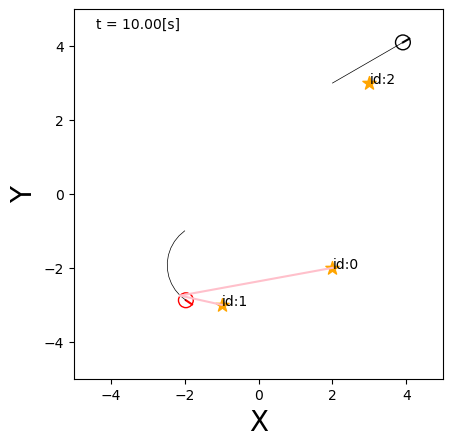

In [11]:
world = World(10, 1.0)
m = Map()
append_landmark(m, Landmark([2,-2]))
append_landmark(m, Landmark([-1,-3]))
append_landmark(m, Landmark([3,3]))
append(world, m)

straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*pi)
robot1 = IdealRobot([2, 3, pi/6], straight, IdealCamera(m),"black")
robot2 = IdealRobot([-2, -1, pi/5*6], circling, IdealCamera(m),"red")
append(world, robot1)
append(world, robot2)
draw(world)

In [12]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAM49tZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAErxliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiASefdwlV7OOckzXd26jK6wIErr1WQUBXEvp/DSgNQ97tXAs3/wekXyhX1Mb3ZVyfb/nuH7YDUTAzDzDUPcJ9aGJDYprkjIs4WNPnmhxrM3XvnMTlFUoqbrQLvpNzo8719ZhI5+0JZaQYm2kUPpjTShXKw7xANuR5lXGYzlr5cI6Ho17qONWYMXE42iHgk8lbYLmkoPjHUk2Oy2lQv27aY/fVfrVFt/VTdo1sv9rKj/xyPGErip3Xb/vVsxHzOfglv+DWCgJihMuLKY4P4M4YYC7KnyHUObr9v+hCqCuPX7tw73SW3wY4C90D1WEjAU7+cX4vPjYbrTlxck/+jMG8V01u4NWmSrIcCUXOuIc/znVJ/Kigeb2s6GLZRFEjGSX2U/5rzp8diJrEu4EXJ/DkNrkdiYPvvTrKN+4tE1J4RjxIdQ0M0tjiPEGY/Tap5/KcmcBVHO5qzuO/7gObO3O8iYnComza9XHUY5nM8qTm6ndGruae8erB/etb0dJNLq8euDhX8x45T79bREfWJMAbMeYOVSHK6x61szIia8EpulzB5sJy3e6n2RZBo5qzhBHe12wOv7l73bxicciy6ycZZMnDVCnZhBQkUw6sewd9SU3crHsN5ubA3hKiT36C359reX8ltlaONYG//S/m7YG9HD9ReKH5K0mHiGopNT988Z5pMog+jeUiTn09vKWZgaLe60fUS9E/FuIWb3KR3CMIk7CJAlwzm8ijcV7mC0IX0AX88v16+1zeQTCb/so/E5ohU5/sW8/ph0XmuQRixP7IBkLhDFhHCrP0gcXobgApGOMqhiIx+5wFdkgRfd8pmPOiTyVUqCQAAffxiQYI6x3QMFOAX1WmUt8ItRgYblr8C2QxtNuOvD4OJqqqk1BrcKLlCFV13JWaXbjZGYkYjfbOl7HkO9+jig4gPLfC3uV6oN+nz2yMc+wtyThtW4wLDwaC2TO8pq86SjPwW2TxLP/O/dR8LDA9btI9vb7sk0wArM0PaSiNfA7GIIuqleaLw55QX1mI1ybTE8wmZBXQzNRccDnjG9ihWyzvcUtBWoRTz63pfFm3WCr/tw+JHROUJ8kFKQlj4mTflAKciFr36KzpZAAi4o+zZM6HOuoax+0k5uQIV1tvkgMswBQQz/ls3tl6sjjL9F2rY7H7rFy+bs68OvtVEV/RHYBykb8LvIof88ENUPqWS5MJMxrUmd0h8X7P7UAtEQQi8vXI2NqRAmqM7+ZSHhAH9w07aPlYAcO1ueu0usfonppJhqjuIe+XWDFlcndbXapmqJ/pbq4Nr3A8gbMdv7pD0P1vOPD7GE9NbX7P/4sXvXxeSNNaz3+K1NR82VUtSHx3aVSkj0EaJFDlAMHA2tphjxEHTx12hW3KknhEA+O3nd9qtTt26gviUO82DhVb3K7IWTqCPgJ+iqBUJdnTzq3ZcwKKe88zwY458Q+MdV3ErNnhNRB0X0E0eb2wYwqxzdQi0bpxoSmSfLD0pyD/w3ga7rsQWVvzNf9/E/snX7Y0uDMlwVG/HyrtXrA8BkpTLTxj6V5F7I9SyGH2BQK4gVd3lqsJtbrFMR/Mo+af9OrKF3rTtfm/BkbPCdmDnUdslK2dkLLW09t/WbgyRIR2WeX7pBP/7f6oMag41mpn7+xHOOe5XGfBf6pu0V6rCKNMhKqjToz1KjlFxxq9LDHLHwAMHsBsLxRbVxmHF0iOtDq8b8VX7jZMdb41ae8HRDxjPUoalez0xvftUS0X0zScaIZ83uPMKTU3xL//29H9itXd7Gluwv1xH9WsURAqfzm1sgwV6jd986dxRViungg3o5keGA4oJGk0BLej9kpDKDsyI24n/zN52wqZ7u7aW0Fqw/fGOAPDov9MD483pE4PxgwYiJADw+IpakjilwKBkWLTC0w/NsDteucQhQhCzUb70WxKDPFB4vaBUVe6xO3g4YvMew1H86qp058vUlHMnhU9Sx5GSzOxmZnWb5SNGc04uuxHR9B5xeoibeOm2jjuaf9nLKzcnliTE4ALmioCl0cd4oyylihhYE5wM9UvP2ns1+Ja+K9VWbQacT289B6x3K1UivyKFPfnX65+Z6wKjYe2kmNoI+aQp0fG/0bfd2eOTIrJCHjTGoWWECP4PYnjcKdAuwuRZvlJ26FwPlYWCqesjM1QvtZoU6Ta8QLc1jLa86OHUvn1ItjmYwKzINgPrszqNSH6FpSbqMDT3VSMlr+REmZ8zCBExgS9juLoz+nX0spVRvfSoNdjzmgGsnjqPSC/8UecrBCg2zsOCCRUQV0WZtcuDdFwP/VPFkfcf1cD1AxXP6Z8NW7esCmDyMXoYxOZeRfRLbgDyBT8ANv8UqsTQFAmWkT56vsgaflswb3HRC8Y3ZCRay6IVHa7vBSBf3ssPaLbNTiTno+LO53+GcaC3Hnt8ynZTmWNHrLVk5Ghh/AWKKjTS0cmlYOj6eleletHXl5S7r4YkJNDab02MWJVLBESArr95cFwGPBLrIbKA56j7jFU24Hs/RC3/EW84/wk3uLysTCUsbrVCPjLKcuxoviuaCYAchCKiSLl6+jdDOfpBOXtp1biP6kKXCgLJ0SknVzTRghGYNXDTrFSCmuexv/3Zgr2bQywAABXPtxJiACEoR2Iq27+gn/mmyOQ2hr82j2Pox3FpAXkCIBjzFP4wcCrMplF5pCdoYPPzI1AZJ7chnxMNvj0BlRUyOtsHUjbrZz1e+DxKrGBvlwlRYb9zY2iD7kBOjhXxNxCSI80Q9mXs7lNxvCcZ9wFHFwZET+8YZOL4DpAOgOn6cBeY23ZUxvSQ5CnMbTcmbk8PjUmHo0O/2zL7FwWY1MqA6cBctmrdRRlWwG55ryDnX62NF/In5j0FmhklcffZiGz+cwwjz/v7obRNeJhWR